In [61]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import os
import pandas as pd
from scipy.stats import entropy
import json
from utils.visualization import plot_example_images, plot_histograms
from utils.datasets import ImageDataset, calculate_mean_std, get_standard_transform, get_ood_transform
from utils.inference import generate_bayesian_predictions
from utils.model_eval import perform_kruskal_dunn_test, plot_boxplot, evaluate_test_performance, generate_ood_classification_report
from training.train import train_model
from utils.misc import get_best_model_config
from models.bayesian_models import BayesianResNet

## Load data

In [ ]:
dir = r"data\Lung Segmentation Data\Lung Segmentation Data" # Assuming data is downloaded in this directory
sub_dirs = ["Train", "Val", "Test"] # Data is already organized in these folders
data = []

for sub_dir in sub_dirs:
    sub_dir_path = os.path.join(dir, sub_dir)
    for label in os.listdir(sub_dir_path):
        label_dir = os.path.join(sub_dir_path, label)
        if os.path.isdir(label_dir):
            for file in os.listdir(os.path.join(label_dir, 'images')):
                if file.endswith(".png"):
                    file_path = os.path.join(label_dir, 'images', file)
                    data.append({"filepath": file_path, "label": label, 'split':sub_dir})

# Create a DataFrame
df = pd.DataFrame(data)

# Define label to class encoding
class_to_label = {'Normal': 0,
                  'Non-COVID': 1,
                  'COVID-19': 2}

label_to_class = {v: k for k, v in class_to_label.items()}

df['encoded_label'] = df['label'].map(class_to_label)
df

,filepath,label,split,encoded_label
0,data\Lung Segmentation Data\Lung Segmentation ...,COVID-19,Train,2
1,data\Lung Segmentation Data\Lung Segmentation ...,COVID-19,Train,2
2,data\Lung Segmentation Data\Lung Segmentation ...,COVID-19,Train,2
3,data\Lung Segmentation Data\Lung Segmentation ...,COVID-19,Train,2
4,data\Lung Segmentation Data\Lung Segmentation ...,COVID-19,Train,2
...,...,...,...,...
33915,data\Lung Segmentation Data\Lung Segmentation ...,Normal,Test,0
33916,data\Lung Segmentation Data\Lung Segmentation ...,Normal,Test,0
33917,data\Lung Segmentation Data\Lung Segmentation ...,Normal,Test,0
33918,data\Lung Segmentation Data\Lung Segmentation ...,Normal,Test,0


In [4]:
df['label'].value_counts()

label
COVID-19     11956
Non-COVID    11263
Normal       10701
Name: count, dtype: int64

Split data into train, validation and test datasets

In [5]:
# Datasets for model to contain normal and non-covid data
train_df = df[(df['split']=='Train') & (df['label']!='COVID-19')].copy().reset_index()
valid_df = df[(df['split']=='Val') & (df['label']!='COVID-19')].copy().reset_index()
test_df = df[(df['split']=='Test') & (df['label']!='COVID-19')].copy().reset_index()

# Data was split by first taking 20% of all data for test, then splitting the rest 80% train and 20% validation
train_df.shape, valid_df.shape, test_df.shape

((14057, 5), (3514, 5), (4393, 5))

In [6]:
train_df

,index,filepath,label,split,encoded_label
0,7658,data\Lung Segmentation Data\Lung Segmentation ...,Non-COVID,Train,1
1,7659,data\Lung Segmentation Data\Lung Segmentation ...,Non-COVID,Train,1
2,7660,data\Lung Segmentation Data\Lung Segmentation ...,Non-COVID,Train,1
3,7661,data\Lung Segmentation Data\Lung Segmentation ...,Non-COVID,Train,1
4,7662,data\Lung Segmentation Data\Lung Segmentation ...,Non-COVID,Train,1
...,...,...,...,...,...
14052,21710,data\Lung Segmentation Data\Lung Segmentation ...,Normal,Train,0
14053,21711,data\Lung Segmentation Data\Lung Segmentation ...,Normal,Train,0
14054,21712,data\Lung Segmentation Data\Lung Segmentation ...,Normal,Train,0
14055,21713,data\Lung Segmentation Data\Lung Segmentation ...,Normal,Train,0


Find mean and std for the train set for data normalization, define transforms to apply to data, get data loaders 

In [7]:
# Load train dataset without transform
train_dataset = ImageDataset(train_df)

# Get mean and std of the train dataset
norm_mean, norm_std = calculate_mean_std(train_dataset)

# Define transforms with normalization mean and std
transform = get_standard_transform(mean=norm_mean, std=norm_std)
ood_transform = get_ood_transform(mean=norm_mean, std=norm_std)

Plot example images

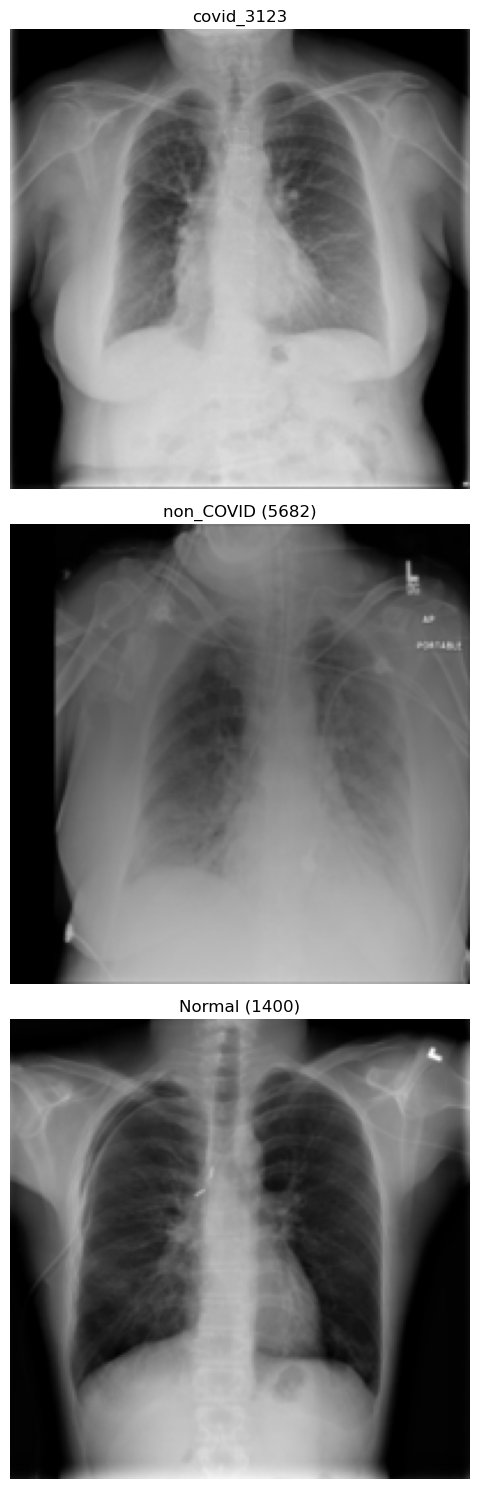

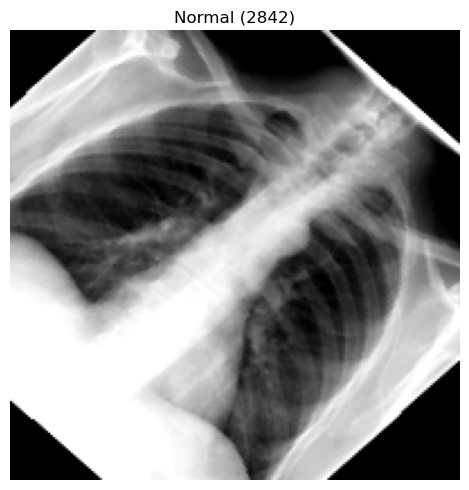

In [ ]:
plot_example_images(df, transform=transform, seed=5, dpi=100)
plot_example_images(df[df['label']=='Normal'], transform=ood_transform, seed=3, dpi=100)

## Hyperparameter tuning

Perform some tuning to identify a good learning rate and batch size.

Define datasets for the model

In [ ]:
# Create datasets for train, validation, and test
train_dataset = ImageDataset(train_df, transform=transform)
valid_dataset = ImageDataset(valid_df, transform=transform)
test_dataset = ImageDataset(test_df, transform=transform)

# Directory to save results
hyperparam_dir = 'experiments/hyperparam_tuning'

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Model class
model_class = BayesianResNet

# Hyperparameter search space
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64]
num_epochs = 10  # Shorter for tuning
print(f'Using {device} for training.\n')

for lr in learning_rates:
    for batch_size in batch_sizes:
        # Create batched data loaders for training and validation
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

        # Train model with parameter configuration and save results
        train_model(
            model_class, 
            train_loader, 
            valid_loader, 
            lr=lr, 
            num_epochs=num_epochs, 
            batch_size=batch_size, 
            kl_weight=1e-3, 
            use_pretrained=False, # start training from scratch
            device=device,
            save_dir=hyperparam_dir,
            random_seed=42,
        )

Using cuda for training.

Training model from scratch...


Epoch 1/10 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.85batch/s]


Epoch [1/10] | Train Loss: 1.3433 | Val Loss: 0.8004
Learning rate after epoch 1: 0.010000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.01_batch_16.pth


Epoch 2/10 - Validation: 100%|██████████| 220/220 [00:12<00:00, 18.27batch/s]


Epoch [2/10] | Train Loss: 0.5928 | Val Loss: 0.4873
Learning rate after epoch 2: 0.010000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.01_batch_16.pth


Epoch 3/10 - Validation: 100%|██████████| 220/220 [00:11<00:00, 18.46batch/s]


Epoch [3/10] | Train Loss: 0.4766 | Val Loss: 0.3953
Learning rate after epoch 3: 0.010000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.01_batch_16.pth


Epoch 4/10 - Validation: 100%|██████████| 220/220 [00:12<00:00, 18.15batch/s]


Epoch [4/10] | Train Loss: 0.4408 | Val Loss: 0.4351
Learning rate after epoch 4: 0.010000


Epoch 5/10 - Validation: 100%|██████████| 220/220 [00:12<00:00, 18.12batch/s]


Epoch [5/10] | Train Loss: 0.4080 | Val Loss: 0.4602
Learning rate after epoch 5: 0.010000


Epoch 6/10 - Validation: 100%|██████████| 220/220 [00:11<00:00, 19.03batch/s]


Epoch [6/10] | Train Loss: 0.3882 | Val Loss: 0.3461
Learning rate after epoch 6: 0.010000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.01_batch_16.pth


Epoch 7/10 - Validation: 100%|██████████| 220/220 [00:11<00:00, 19.53batch/s]


Epoch [7/10] | Train Loss: 0.3609 | Val Loss: 0.3934
Learning rate after epoch 7: 0.010000


Epoch 8/10 - Validation: 100%|██████████| 220/220 [00:12<00:00, 18.33batch/s]


Epoch [8/10] | Train Loss: 0.3432 | Val Loss: 0.3076
Learning rate after epoch 8: 0.010000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.01_batch_16.pth


Epoch 9/10 - Validation: 100%|██████████| 220/220 [00:11<00:00, 19.07batch/s]


Epoch [9/10] | Train Loss: 0.3317 | Val Loss: 0.2943
Learning rate after epoch 9: 0.010000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.01_batch_16.pth


Epoch 10/10 - Validation: 100%|██████████| 220/220 [00:11<00:00, 18.50batch/s]


Epoch [10/10] | Train Loss: 0.3173 | Val Loss: 0.3026
Learning rate after epoch 10: 0.010000
Training model from scratch...


Epoch 1/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.98batch/s]


Epoch [1/10] | Train Loss: 1.7072 | Val Loss: 0.9503
Learning rate after epoch 1: 0.010000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.01_batch_32.pth


Epoch 2/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.62batch/s]


Epoch [2/10] | Train Loss: 0.7511 | Val Loss: 0.7228
Learning rate after epoch 2: 0.010000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.01_batch_32.pth


Epoch 3/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.48batch/s]


Epoch [3/10] | Train Loss: 0.5498 | Val Loss: 0.5636
Learning rate after epoch 3: 0.010000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.01_batch_32.pth


Epoch 4/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.50batch/s]


Epoch [4/10] | Train Loss: 0.4639 | Val Loss: 0.5038
Learning rate after epoch 4: 0.010000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.01_batch_32.pth


Epoch 5/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.42batch/s]


Epoch [5/10] | Train Loss: 0.4189 | Val Loss: 0.3643
Learning rate after epoch 5: 0.010000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.01_batch_32.pth


Epoch 6/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.51batch/s]


Epoch [6/10] | Train Loss: 0.3777 | Val Loss: 0.3227
Learning rate after epoch 6: 0.010000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.01_batch_32.pth


Epoch 7/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.43batch/s]


Epoch [7/10] | Train Loss: 0.3613 | Val Loss: 0.3570
Learning rate after epoch 7: 0.010000


Epoch 8/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.57batch/s]


Epoch [8/10] | Train Loss: 0.3485 | Val Loss: 0.4201
Learning rate after epoch 8: 0.010000


Epoch 9/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.52batch/s]


Epoch [9/10] | Train Loss: 0.3257 | Val Loss: 0.3197
Learning rate after epoch 9: 0.010000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.01_batch_32.pth


Epoch 10/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.83batch/s]


Epoch [10/10] | Train Loss: 0.3040 | Val Loss: 0.3077
Learning rate after epoch 10: 0.010000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.01_batch_32.pth
Training model from scratch...


Epoch 1/10 - Validation: 100%|██████████| 55/55 [00:11<00:00,  5.00batch/s]


Epoch [1/10] | Train Loss: 1.8785 | Val Loss: 1.3995
Learning rate after epoch 1: 0.010000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.01_batch_64.pth


Epoch 2/10 - Validation: 100%|██████████| 55/55 [00:11<00:00,  4.90batch/s]


Epoch [2/10] | Train Loss: 1.0028 | Val Loss: 0.7978
Learning rate after epoch 2: 0.010000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.01_batch_64.pth


Epoch 3/10 - Validation: 100%|██████████| 55/55 [00:11<00:00,  4.98batch/s]


Epoch [3/10] | Train Loss: 0.7444 | Val Loss: 0.6404
Learning rate after epoch 3: 0.010000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.01_batch_64.pth


Epoch 4/10 - Validation: 100%|██████████| 55/55 [00:11<00:00,  4.90batch/s]


Epoch [4/10] | Train Loss: 0.5927 | Val Loss: 0.5239
Learning rate after epoch 4: 0.010000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.01_batch_64.pth


Epoch 5/10 - Validation: 100%|██████████| 55/55 [00:10<00:00,  5.02batch/s]


Epoch [5/10] | Train Loss: 0.5281 | Val Loss: 0.4183
Learning rate after epoch 5: 0.010000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.01_batch_64.pth


Epoch 6/10 - Validation: 100%|██████████| 55/55 [00:11<00:00,  4.81batch/s]


Epoch [6/10] | Train Loss: 0.4438 | Val Loss: 0.4155
Learning rate after epoch 6: 0.010000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.01_batch_64.pth


Epoch 7/10 - Validation: 100%|██████████| 55/55 [00:11<00:00,  4.99batch/s]


Epoch [7/10] | Train Loss: 0.4780 | Val Loss: 0.3958
Learning rate after epoch 7: 0.010000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.01_batch_64.pth


Epoch 8/10 - Validation: 100%|██████████| 55/55 [00:11<00:00,  4.89batch/s]


Epoch [8/10] | Train Loss: 0.4238 | Val Loss: 0.4446
Learning rate after epoch 8: 0.010000


Epoch 9/10 - Validation: 100%|██████████| 55/55 [00:11<00:00,  4.96batch/s]


Epoch [9/10] | Train Loss: 0.3978 | Val Loss: 0.4013
Learning rate after epoch 9: 0.010000


Epoch 10/10 - Validation: 100%|██████████| 55/55 [00:11<00:00,  4.93batch/s]


Epoch [10/10] | Train Loss: 0.3800 | Val Loss: 0.4058
Learning rate after epoch 10: 0.010000
Training model from scratch...


Epoch 1/10 - Validation: 100%|██████████| 220/220 [00:11<00:00, 18.37batch/s]


Epoch [1/10] | Train Loss: 1.7888 | Val Loss: 1.3223
Learning rate after epoch 1: 0.001000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.001_batch_16.pth


Epoch 2/10 - Validation: 100%|██████████| 220/220 [00:11<00:00, 18.47batch/s]


Epoch [2/10] | Train Loss: 1.2740 | Val Loss: 1.4979
Learning rate after epoch 2: 0.001000


Epoch 3/10 - Validation: 100%|██████████| 220/220 [00:12<00:00, 18.19batch/s]


Epoch [3/10] | Train Loss: 0.9943 | Val Loss: 0.8398
Learning rate after epoch 3: 0.001000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.001_batch_16.pth


Epoch 4/10 - Validation: 100%|██████████| 220/220 [00:12<00:00, 18.06batch/s]


Epoch [4/10] | Train Loss: 0.7729 | Val Loss: 0.6655
Learning rate after epoch 4: 0.001000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.001_batch_16.pth


Epoch 5/10 - Validation: 100%|██████████| 220/220 [00:12<00:00, 18.14batch/s]


Epoch [5/10] | Train Loss: 0.6199 | Val Loss: 0.9863
Learning rate after epoch 5: 0.001000


Epoch 6/10 - Validation: 100%|██████████| 220/220 [00:11<00:00, 18.44batch/s]


Epoch [6/10] | Train Loss: 0.5156 | Val Loss: 0.4493
Learning rate after epoch 6: 0.001000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.001_batch_16.pth


Epoch 7/10 - Validation: 100%|██████████| 220/220 [00:12<00:00, 18.22batch/s]


Epoch [7/10] | Train Loss: 0.4325 | Val Loss: 0.4321
Learning rate after epoch 7: 0.001000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.001_batch_16.pth


Epoch 8/10 - Validation: 100%|██████████| 220/220 [00:12<00:00, 18.19batch/s]


Epoch [8/10] | Train Loss: 0.3942 | Val Loss: 0.4826
Learning rate after epoch 8: 0.001000


Epoch 9/10 - Validation: 100%|██████████| 220/220 [00:12<00:00, 18.23batch/s]


Epoch [9/10] | Train Loss: 0.3550 | Val Loss: 0.3358
Learning rate after epoch 9: 0.001000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.001_batch_16.pth


Epoch 10/10 - Validation: 100%|██████████| 220/220 [00:12<00:00, 18.15batch/s]


Epoch [10/10] | Train Loss: 0.3310 | Val Loss: 0.3152
Learning rate after epoch 10: 0.001000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.001_batch_16.pth
Training model from scratch...


Epoch 1/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.68batch/s]


Epoch [1/10] | Train Loss: 1.9440 | Val Loss: 1.5961
Learning rate after epoch 1: 0.001000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.001_batch_32.pth


Epoch 2/10 - Validation: 100%|██████████| 110/110 [00:10<00:00, 10.45batch/s]


Epoch [2/10] | Train Loss: 1.4752 | Val Loss: 1.3160
Learning rate after epoch 2: 0.001000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.001_batch_32.pth


Epoch 3/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.57batch/s]


Epoch [3/10] | Train Loss: 1.2858 | Val Loss: 1.1097
Learning rate after epoch 3: 0.001000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.001_batch_32.pth


Epoch 4/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.73batch/s]


Epoch [4/10] | Train Loss: 1.1120 | Val Loss: 1.1461
Learning rate after epoch 4: 0.001000


Epoch 5/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.65batch/s]


Epoch [5/10] | Train Loss: 0.9615 | Val Loss: 0.8808
Learning rate after epoch 5: 0.001000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.001_batch_32.pth


Epoch 6/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.48batch/s]


Epoch [6/10] | Train Loss: 0.8435 | Val Loss: 0.7105
Learning rate after epoch 6: 0.001000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.001_batch_32.pth


Epoch 7/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.66batch/s]


Epoch [7/10] | Train Loss: 0.7245 | Val Loss: 0.7401
Learning rate after epoch 7: 0.001000


Epoch 8/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.66batch/s]


Epoch [8/10] | Train Loss: 0.6217 | Val Loss: 0.5631
Learning rate after epoch 8: 0.001000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.001_batch_32.pth


Epoch 9/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.59batch/s]


Epoch [9/10] | Train Loss: 0.5392 | Val Loss: 0.4721
Learning rate after epoch 9: 0.001000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.001_batch_32.pth


Epoch 10/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.50batch/s]


Epoch [10/10] | Train Loss: 0.4563 | Val Loss: 0.4360
Learning rate after epoch 10: 0.001000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.001_batch_32.pth
Training model from scratch...


Epoch 1/10 - Validation: 100%|██████████| 55/55 [00:11<00:00,  4.97batch/s]


Epoch [1/10] | Train Loss: 1.9649 | Val Loss: 1.6280
Learning rate after epoch 1: 0.001000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.001_batch_64.pth


Epoch 2/10 - Validation: 100%|██████████| 55/55 [00:10<00:00,  5.03batch/s]


Epoch [2/10] | Train Loss: 1.4853 | Val Loss: 1.4985
Learning rate after epoch 2: 0.001000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.001_batch_64.pth


Epoch 3/10 - Validation: 100%|██████████| 55/55 [00:11<00:00,  4.80batch/s]


Epoch [3/10] | Train Loss: 1.3431 | Val Loss: 1.3014
Learning rate after epoch 3: 0.001000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.001_batch_64.pth


Epoch 4/10 - Validation: 100%|██████████| 55/55 [00:10<00:00,  5.05batch/s]


Epoch [4/10] | Train Loss: 1.2140 | Val Loss: 1.1771
Learning rate after epoch 4: 0.001000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.001_batch_64.pth


Epoch 5/10 - Validation: 100%|██████████| 55/55 [00:11<00:00,  4.82batch/s]


Epoch [5/10] | Train Loss: 1.1185 | Val Loss: 0.9880
Learning rate after epoch 5: 0.001000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.001_batch_64.pth


Epoch 6/10 - Validation: 100%|██████████| 55/55 [00:11<00:00,  4.96batch/s]


Epoch [6/10] | Train Loss: 0.9810 | Val Loss: 0.9808
Learning rate after epoch 6: 0.001000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.001_batch_64.pth


Epoch 7/10 - Validation: 100%|██████████| 55/55 [00:11<00:00,  4.97batch/s]


Epoch [7/10] | Train Loss: 0.9193 | Val Loss: 1.8215
Learning rate after epoch 7: 0.001000


Epoch 8/10 - Validation: 100%|██████████| 55/55 [00:11<00:00,  4.99batch/s]


Epoch [8/10] | Train Loss: 0.8413 | Val Loss: 0.8486
Learning rate after epoch 8: 0.001000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.001_batch_64.pth


Epoch 9/10 - Validation: 100%|██████████| 55/55 [00:11<00:00,  4.92batch/s]


Epoch [9/10] | Train Loss: 0.7195 | Val Loss: 0.7278
Learning rate after epoch 9: 0.001000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.001_batch_64.pth


Epoch 10/10 - Validation: 100%|██████████| 55/55 [00:10<00:00,  5.04batch/s]


Epoch [10/10] | Train Loss: 0.6465 | Val Loss: 0.5902
Learning rate after epoch 10: 0.001000
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.001_batch_64.pth
Training model from scratch...


Epoch 1/10 - Validation: 100%|██████████| 220/220 [00:11<00:00, 18.35batch/s]


Epoch [1/10] | Train Loss: 1.8401 | Val Loss: 1.5588
Learning rate after epoch 1: 0.000100
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.0001_batch_16.pth


Epoch 2/10 - Validation: 100%|██████████| 220/220 [00:11<00:00, 18.50batch/s]


Epoch [2/10] | Train Loss: 1.6047 | Val Loss: 1.6247
Learning rate after epoch 2: 0.000100


Epoch 3/10 - Validation: 100%|██████████| 220/220 [00:11<00:00, 18.56batch/s]


Epoch [3/10] | Train Loss: 1.4798 | Val Loss: 1.4467
Learning rate after epoch 3: 0.000100
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.0001_batch_16.pth


Epoch 4/10 - Validation: 100%|██████████| 220/220 [00:11<00:00, 18.42batch/s]


Epoch [4/10] | Train Loss: 1.3988 | Val Loss: 1.3483
Learning rate after epoch 4: 0.000100
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.0001_batch_16.pth


Epoch 5/10 - Validation: 100%|██████████| 220/220 [00:12<00:00, 18.19batch/s]


Epoch [5/10] | Train Loss: 1.3062 | Val Loss: 1.5076
Learning rate after epoch 5: 0.000100


Epoch 6/10 - Validation: 100%|██████████| 220/220 [00:11<00:00, 19.44batch/s]


Epoch [6/10] | Train Loss: 1.2457 | Val Loss: 1.2852
Learning rate after epoch 6: 0.000100
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.0001_batch_16.pth


Epoch 7/10 - Validation: 100%|██████████| 220/220 [00:12<00:00, 18.24batch/s]


Epoch [7/10] | Train Loss: 1.1493 | Val Loss: 1.2636
Learning rate after epoch 7: 0.000100
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.0001_batch_16.pth


Epoch 8/10 - Validation: 100%|██████████| 220/220 [00:11<00:00, 18.45batch/s]


Epoch [8/10] | Train Loss: 1.0547 | Val Loss: 1.2592
Learning rate after epoch 8: 0.000100
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.0001_batch_16.pth


Epoch 9/10 - Validation: 100%|██████████| 220/220 [00:12<00:00, 18.22batch/s]


Epoch [9/10] | Train Loss: 0.9780 | Val Loss: 1.1754
Learning rate after epoch 9: 0.000100
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.0001_batch_16.pth


Epoch 10/10 - Validation: 100%|██████████| 220/220 [00:11<00:00, 18.40batch/s]


Epoch [10/10] | Train Loss: 0.8857 | Val Loss: 1.1234
Learning rate after epoch 10: 0.000100
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.0001_batch_16.pth
Training model from scratch...


Epoch 1/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.62batch/s]


Epoch [1/10] | Train Loss: 1.8434 | Val Loss: 1.6266
Learning rate after epoch 1: 0.000100
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.0001_batch_32.pth


Epoch 2/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.47batch/s]


Epoch [2/10] | Train Loss: 1.6443 | Val Loss: 1.5459
Learning rate after epoch 2: 0.000100
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.0001_batch_32.pth


Epoch 3/10 - Validation: 100%|██████████| 110/110 [00:10<00:00, 10.01batch/s]


Epoch [3/10] | Train Loss: 1.5448 | Val Loss: 1.5314
Learning rate after epoch 3: 0.000100
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.0001_batch_32.pth


Epoch 4/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.48batch/s]


Epoch [4/10] | Train Loss: 1.4245 | Val Loss: 1.4666
Learning rate after epoch 4: 0.000100
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.0001_batch_32.pth


Epoch 5/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.36batch/s]


Epoch [5/10] | Train Loss: 1.3400 | Val Loss: 1.5350
Learning rate after epoch 5: 0.000100


Epoch 6/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.59batch/s]


Epoch [6/10] | Train Loss: 1.2777 | Val Loss: 1.4175
Learning rate after epoch 6: 0.000100
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.0001_batch_32.pth


Epoch 7/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.57batch/s]


Epoch [7/10] | Train Loss: 1.2299 | Val Loss: 1.7601
Learning rate after epoch 7: 0.000100


Epoch 8/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.63batch/s]


Epoch [8/10] | Train Loss: 1.1530 | Val Loss: 1.5695
Learning rate after epoch 8: 0.000100


Epoch 9/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.61batch/s]


Epoch [9/10] | Train Loss: 1.0751 | Val Loss: 1.4823
Learning rate after epoch 9: 0.000100


Epoch 10/10 - Validation: 100%|██████████| 110/110 [00:11<00:00,  9.60batch/s]


Epoch [10/10] | Train Loss: 1.0433 | Val Loss: 1.5214
Learning rate after epoch 10: 0.000050
Training model from scratch...


Epoch 1/10 - Validation: 100%|██████████| 55/55 [00:10<00:00,  5.02batch/s]


Epoch [1/10] | Train Loss: 1.8758 | Val Loss: 1.8066
Learning rate after epoch 1: 0.000100
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.0001_batch_64.pth


Epoch 2/10 - Validation: 100%|██████████| 55/55 [00:11<00:00,  4.92batch/s]


Epoch [2/10] | Train Loss: 1.6170 | Val Loss: 2.0096
Learning rate after epoch 2: 0.000100


Epoch 3/10 - Validation: 100%|██████████| 55/55 [00:11<00:00,  4.87batch/s]


Epoch [3/10] | Train Loss: 1.5503 | Val Loss: 1.6396
Learning rate after epoch 3: 0.000100
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.0001_batch_64.pth


Epoch 4/10 - Validation: 100%|██████████| 55/55 [00:11<00:00,  4.88batch/s]


Epoch [4/10] | Train Loss: 1.4367 | Val Loss: 1.5340
Learning rate after epoch 4: 0.000100
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.0001_batch_64.pth


Epoch 5/10 - Validation: 100%|██████████| 55/55 [00:11<00:00,  5.00batch/s]


Epoch [5/10] | Train Loss: 1.3611 | Val Loss: 1.4823
Learning rate after epoch 5: 0.000100
Checkpoint saved: experiments/hyperparam_tuning\best_model_lr_0.0001_batch_64.pth


Epoch 6/10 - Validation: 100%|██████████| 55/55 [00:11<00:00,  4.89batch/s]


Epoch [6/10] | Train Loss: 1.2511 | Val Loss: 1.5318
Learning rate after epoch 6: 0.000100


Epoch 7/10 - Validation: 100%|██████████| 55/55 [00:11<00:00,  4.97batch/s]


Epoch [7/10] | Train Loss: 1.1973 | Val Loss: 1.6894
Learning rate after epoch 7: 0.000100


Epoch 8/10 - Validation: 100%|██████████| 55/55 [00:11<00:00,  5.00batch/s]


Epoch [8/10] | Train Loss: 1.1493 | Val Loss: 1.7830
Learning rate after epoch 8: 0.000100


Epoch 9/10 - Validation: 100%|██████████| 55/55 [00:11<00:00,  4.93batch/s]


Epoch [9/10] | Train Loss: 1.1034 | Val Loss: 1.6299
Learning rate after epoch 9: 0.000050


Epoch 10/10 - Validation: 100%|██████████| 55/55 [00:10<00:00,  5.01batch/s]

Epoch [10/10] | Train Loss: 1.0391 | Val Loss: 1.5750
Learning rate after epoch 10: 0.000050


## Model training

Load best model from config and define data loaders

In [17]:
model_class = BayesianResNet

# Parse results file to find and load the best model (lowest validation loss)
result_path = os.path.join(hyperparam_dir, 'results.json')
config = get_best_model_config(result_path)

# Get params from config
lr = config['lr'] # this is the starting rate (can be modified by scheduler during training)
batch_size = config['batch_size']
checkpoint_path = config['checkpoint_path']

# Directory to save fine tuning results
ft_dir = 'experiments/fine_tuning'

# Get data loaders with the appropriate batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

Best checkpoint found at: experiments/hyperparam_tuning\checkpoints\best_model_lr_0.01_batch_16.pth
Best validation loss: 0.2683024340224537


Fine tune model with selected hyperparameters

In [12]:
# Additional epochs
num_epochs = 10

# Fine-tuning with the best configuration
train_model(
    model_class, 
    train_loader, 
    valid_loader, 
    lr=lr, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    kl_weight=1e-3, 
    use_pretrained=True, # continue training
    checkpoint_path=checkpoint_path, # path of model checkpoint from best config
    device=device,
    save_dir=ft_dir,
    random_seed=42
)

Loading pre-trained weights and optimizer state from experiments/hyperparam_tuning\checkpoints\best_model_lr_0.01_batch_16.pth


Epoch 11/20 - Validation: 100%|██████████| 220/220 [00:11<00:00, 18.64batch/s]


Epoch [11/20] | Train Loss: 0.3157 | Val Loss: 0.2486
Learning rate after epoch 11: 0.010000
Checkpoint saved: experiments/fine_tuning\best_model_lr_0.01_batch_16.pth


Epoch 12/20 - Validation: 100%|██████████| 220/220 [00:11<00:00, 18.52batch/s]


Epoch [12/20] | Train Loss: 0.2712 | Val Loss: 0.3939
Learning rate after epoch 12: 0.010000


Epoch 13/20 - Validation: 100%|██████████| 220/220 [00:11<00:00, 18.79batch/s]


Epoch [13/20] | Train Loss: 0.2488 | Val Loss: 0.2987
Learning rate after epoch 13: 0.010000


Epoch 14/20 - Validation: 100%|██████████| 220/220 [00:11<00:00, 18.41batch/s]


Epoch [14/20] | Train Loss: 0.2382 | Val Loss: 0.2917
Learning rate after epoch 14: 0.010000


Epoch 15/20 - Validation: 100%|██████████| 220/220 [00:11<00:00, 18.68batch/s]


Epoch [15/20] | Train Loss: 0.2114 | Val Loss: 0.2809
Learning rate after epoch 15: 0.005000


Epoch 16/20 - Validation: 100%|██████████| 220/220 [00:11<00:00, 18.69batch/s]


Epoch [16/20] | Train Loss: 0.1480 | Val Loss: 0.2891
Learning rate after epoch 16: 0.005000


Epoch 17/20 - Validation: 100%|██████████| 220/220 [00:11<00:00, 18.58batch/s]


Epoch [17/20] | Train Loss: 0.1172 | Val Loss: 0.3169
Learning rate after epoch 17: 0.005000


Epoch 18/20 - Validation: 100%|██████████| 220/220 [00:11<00:00, 18.58batch/s]


Epoch [18/20] | Train Loss: 0.0809 | Val Loss: 0.3908
Learning rate after epoch 18: 0.005000


Epoch 19/20 - Validation: 100%|██████████| 220/220 [00:11<00:00, 18.69batch/s]


Epoch [19/20] | Train Loss: 0.0660 | Val Loss: 0.3883
Learning rate after epoch 19: 0.002500


Epoch 20/20 - Validation: 100%|██████████| 220/220 [00:11<00:00, 18.44batch/s]

Epoch [20/20] | Train Loss: 0.0340 | Val Loss: 0.4011
Learning rate after epoch 20: 0.002500


## Variational inference

For variational inference, for each sample in the data loader, model.eval() performs multiple stochastic forward passes via the Bayesian layers. Each forward pass samples from the weight distributions (thanks to the reparametrization trick), producing slightly different results. Multiple predictions are aggregated and a mean prediction is calculated.

In [18]:
# Parse results file to find and load the best model (lowest validation loss)
result_path = os.path.join(ft_dir, 'results.json')
config = get_best_model_config(result_path)
checkpoint_path = config['checkpoint_path']

# Load model from config path
checkpoint = torch.load(checkpoint_path)
model = model_class(num_classes=2).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

Best checkpoint found at: experiments/fine_tuning\best_model_lr_0.01_batch_16.pth
Best validation loss: 0.24859546531330456


<All keys matched successfully>

Load data for inference:
- Normal test data.
- Non-covid infection test data.
- COVID-19 data (not used for model training).
- Normal test data with OOD transformations.

In [10]:
# Number of images to use for inference for each dataset
n_infer = 2000
seed = 1

# Sample subsets for inference
noncovid_samples = test_df[test_df['label'] == 'Non-COVID'].sample(n=n_infer, random_state=seed).copy().reset_index()
normal_samples = test_df[test_df['label'] == 'Normal'].sample(n=n_infer, random_state=seed).copy().reset_index()

# OOD samples from unused data
covid_samples = df[df['label'] == 'COVID-19'].sample(n=n_infer, random_state=seed).copy().reset_index()

# Create datasets for inference
noncovid_ds = ImageDataset(noncovid_samples, transform=transform)
normal_ds = ImageDataset(normal_samples, transform=transform)
covid_ds = ImageDataset(covid_samples, transform=transform)
ood_ds = ImageDataset(normal_samples, transform=ood_transform) # applies ood transform to normal test data

# Create dataloaders
noncovid_loader = DataLoader(noncovid_ds, batch_size=64, shuffle=False)
normal_loader = DataLoader(normal_ds, batch_size=64, shuffle=False)
covid_loader = DataLoader(covid_ds, batch_size=64, shuffle=False)
ood_loader = DataLoader(ood_ds, batch_size=64, shuffle=False) 

# Store loaders in a dictionary
data_loaders = {
    "normal": normal_loader,
    "noncovid": noncovid_loader,
    "covid": covid_loader,
    "ood_transforms": ood_loader
}

# Extract true labels from loaders
# Initialize an empty dictionary to store true labels
true_labels_dict = {}

# Iterate over each loader in the data_loaders dictionary
for loader_name, loader in data_loaders.items():
    # Initialize a list to store true labels for the current loader
    all_true_labels = []
    
    # Iterate over batches in the loader
    for images, labels in loader:
        all_true_labels.append(labels.numpy())  # Convert labels to numpy array and append

    # Concatenate all the true labels for the current loader and save to the dictionary
    true_labels_dict[loader_name] = np.concatenate(all_true_labels)

Perform inference

In [19]:
# Directory to save inference results
inference_dir = 'experiments/inference'
os.makedirs(inference_dir, exist_ok=True)

In [20]:
model.eval()

# Dict to store results
results = {}

num_samples = 100

for name, loader in data_loaders.items():
    print(f"Running inference for {n_infer} {name} samples for {num_samples} passes...")

    # Run Bayesian predictions
    all_preds, all_kl_divs = generate_bayesian_predictions(model, loader, device, num_samples=num_samples)
    
    # Convert predictions and KL divergences to numpy for saving
    all_preds_numpy = all_preds.cpu().numpy()
    all_kl_divs_numpy = np.array(all_kl_divs)

    # Save predictions and KL divergences to separate files
    pred_file = os.path.join(inference_dir, f"{name}_predictions.npy")
    kl_file = os.path.join(inference_dir, f"{name}_kl_divergences.npy")

    np.save(pred_file, all_preds_numpy)
    np.save(kl_file, all_kl_divs_numpy)

    print(f"Saved predictions to {pred_file}")
    print(f"Saved KL divergences to {kl_file}")

    # Store results metadata in the results dictionary
    results[name] = {
        "predictions_file": pred_file,
        "kl_divergences_file": kl_file,
    }

# Save results metadata to a JSON file
results_file = os.path.join(inference_dir, "results_metadata.json")
with open(results_file, "w") as f:
    json.dump(results, f, indent=4)

print(f"Results metadata saved to {results_file}")


Running inference for 2000 normal samples for 100 passes...


KeyboardInterrupt: 

Inference was accidentally restarted but predictions had been saved previously. Results are loaded below.

## Model performance and uncertainty analysis

Load inference data

In [21]:
# Path to metadata file
results_file = os.path.join(inference_dir, "results_metadata.json")

# Load metadata
with open(results_file, "r") as f:
    results = json.load(f)

# Load predictions and KL divergences
loaded_results = {}
for name, paths in results.items():
    print(f"Loading data for {name}...")

    # Load predictions
    predictions_file = paths["predictions_file"]
    kl_divergences_file = paths["kl_divergences_file"]

    predictions = np.load(predictions_file)  # Shape: [num_samples, num_images, num_classes]
    kl_divergences = np.load(kl_divergences_file)  # Shape: [num_samples]

    # Store in a dictionary for easy access
    loaded_results[name] = {
        "predictions": predictions,
        "kl_divergences": kl_divergences,
    }

    print(f"Loaded predictions from {predictions_file} with shape {predictions.shape}")
    print(f"Loaded KL divergences from {kl_divergences_file} with {len(kl_divergences)} samples")

Loading data for normal...
Loaded predictions from experiments/inference\normal_predictions.npy with shape (100, 2000, 2)
Loaded KL divergences from experiments/inference\normal_kl_divergences.npy with 3200 samples
Loading data for noncovid...
Loaded predictions from experiments/inference\noncovid_predictions.npy with shape (100, 2000, 2)
Loaded KL divergences from experiments/inference\noncovid_kl_divergences.npy with 3200 samples
Loading data for covid...
Loaded predictions from experiments/inference\covid_predictions.npy with shape (100, 2000, 2)
Loaded KL divergences from experiments/inference\covid_kl_divergences.npy with 3200 samples
Loading data for ood_transforms...
Loaded predictions from experiments/inference\ood_transforms_predictions.npy with shape (100, 2000, 2)
Loaded KL divergences from experiments/inference\ood_transforms_kl_divergences.npy with 3200 samples


Get model predictions; analyze predication variance and entropy.

In [22]:
# Store all variances for combined histogram
category_variances = {}
category_entropies = {}
category_pred_labels = {}


for name in loaded_results.keys():
    all_preds = torch.from_numpy(loaded_results[name]['predictions'])
    mean_preds = torch.mean(all_preds, axis=0) # mean of logits across forward passes
    mean_preds_prob = F.softmax(mean_preds, dim=1) # tensor of mean softmax probabilities shape [num_images x num_classes]

    # Get predicted labels as the highest probability prediction
    pred_labels = torch.argmax(mean_preds_prob, axis=1)

    # Mean prediction probabilities and prediction variance
    var_preds = torch.var(all_preds, axis=0) # tensor of probability variance across forward passes shape [num_images x num_classes]

    # Variance across classes for a given input (epistemic uncertainty) - take as mean variance of each image
    uncertainty_variance = torch.mean(var_preds, axis=1).numpy()

    # Entropy for mean prediction
    uncertainty_entropy = entropy(mean_preds_prob.T) # transpose as each column is expected to be the probability distribution for entropy calculation

    # Append to all predicted labels, entropies and variances
    category_pred_labels[name] = pred_labels
    category_entropies[name] = uncertainty_entropy
    category_variances[name] = uncertainty_variance


### Model evaluation for test and OOD data

Analyze performance for the whole test dataset

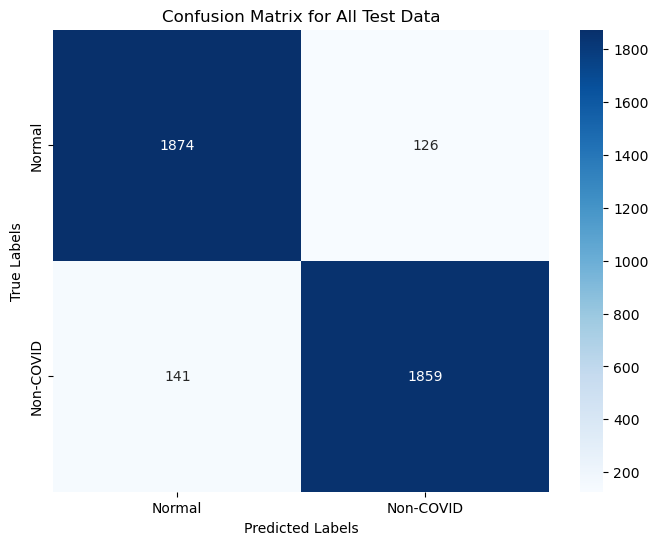


Aggregate Metrics for Test Data:
  Accuracy: 0.9333
  Precision (weighted): 0.9333
  Recall (weighted): 0.9333
  F1-Score (weighted): 0.9332


In [64]:
test_keys = ["normal", "noncovid"]
metrics = evaluate_test_performance(true_labels_dict, category_pred_labels, test_keys, class_to_label, output_dir="plots", dpi=500)

Analyze classification results for OOD data

In [162]:
ood_keys = ["covid", "ood_transforms"] #ood_transforms is normal test data + ood transforms
ood_predictions = generate_ood_classification_report(category_pred_labels, ood_keys, class_to_label)


Prediction Counts for OOD Data (covid):
  Normal: 990
  Non-COVID: 1010

Prediction Counts for OOD Data (ood_transforms):
  Normal: 636
  Non-COVID: 1364


### Uncertainty analysis

Saved histogram for normal to plots\normal_variance_histogram.png


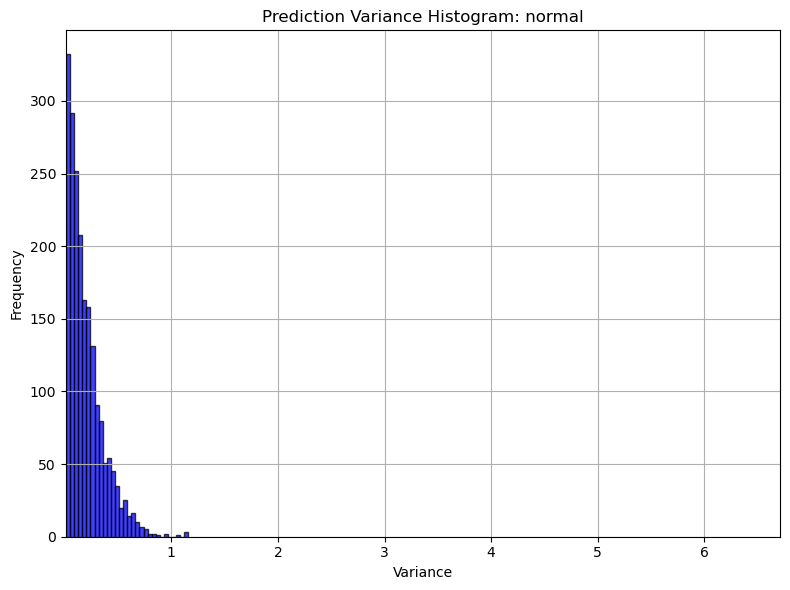

Saved histogram for noncovid to plots\noncovid_variance_histogram.png


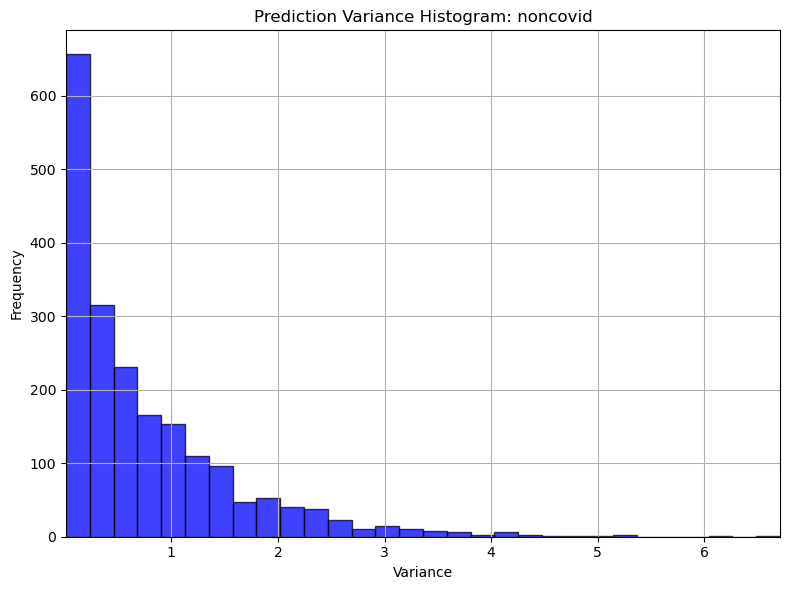

Saved histogram for covid to plots\covid_variance_histogram.png


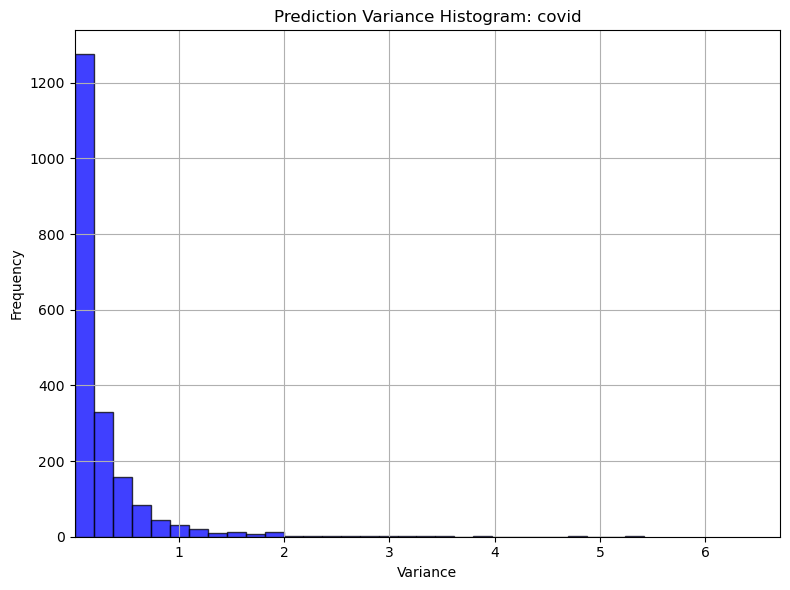

Saved histogram for ood_transforms to plots\ood_transforms_variance_histogram.png


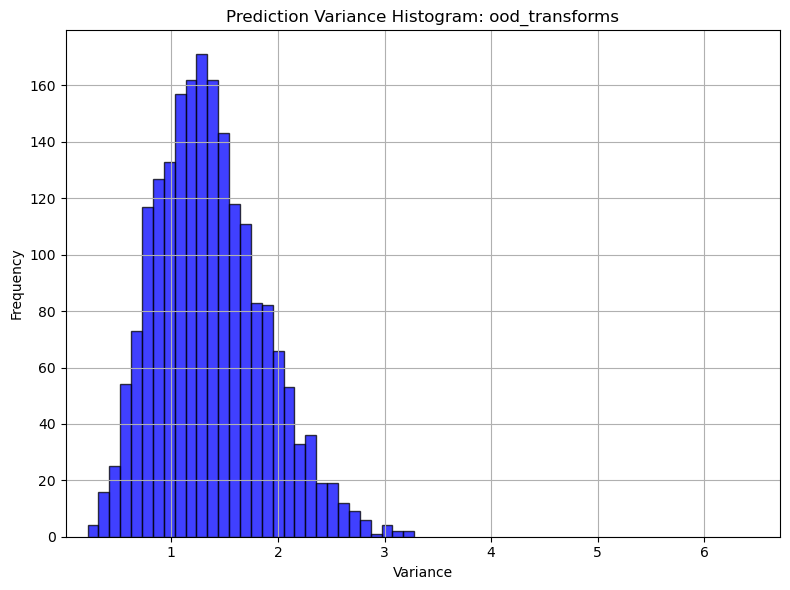

Saved histogram for normal to plots\normal_entropy_histogram.png


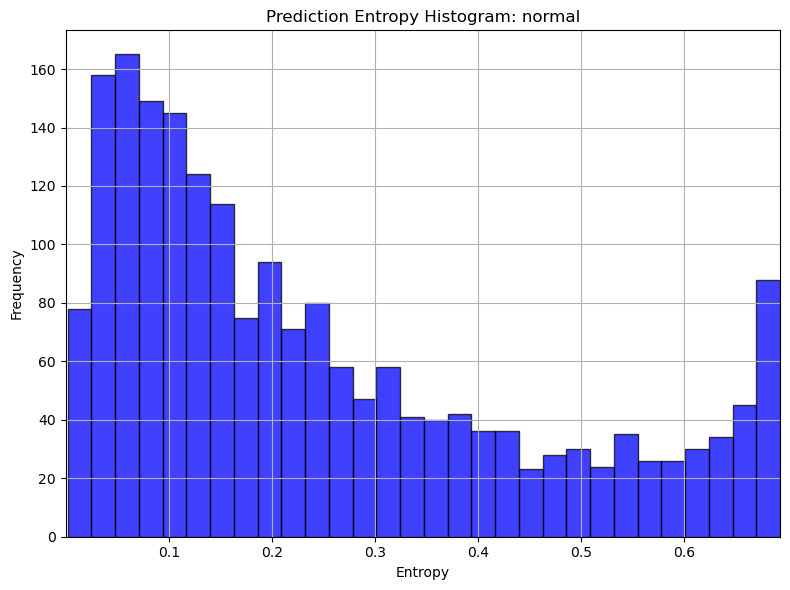

Saved histogram for noncovid to plots\noncovid_entropy_histogram.png


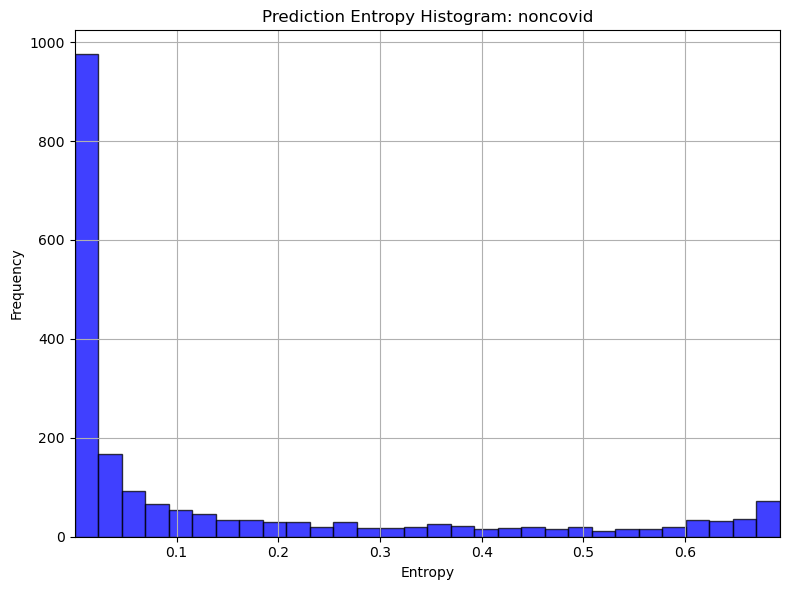

Saved histogram for covid to plots\covid_entropy_histogram.png


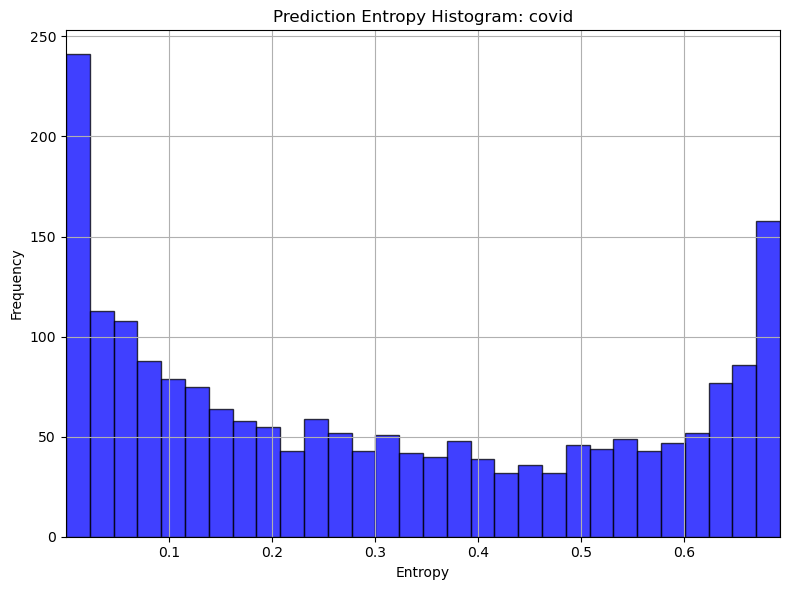

Saved histogram for ood_transforms to plots\ood_transforms_entropy_histogram.png


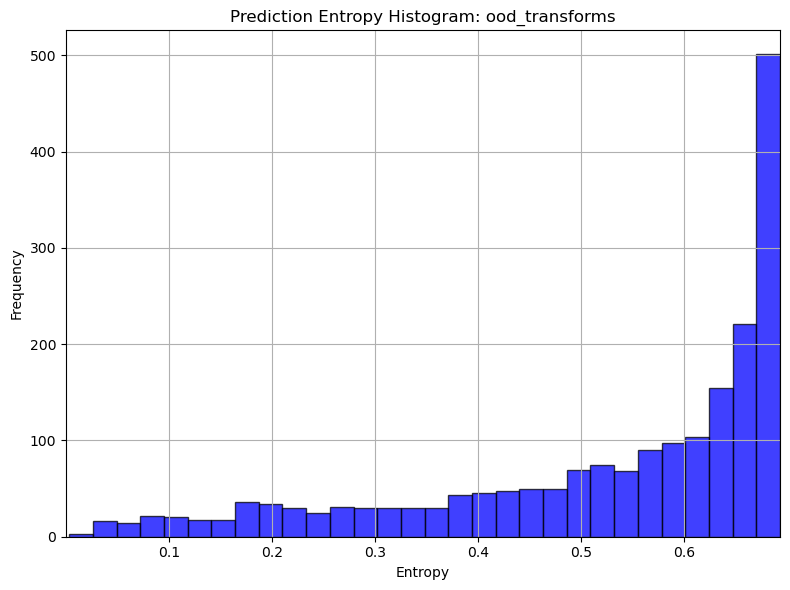

In [44]:
plot_histograms(category_variances, 'variance', dpi=100,  output_dir='plots')
plot_histograms(category_entropies, 'entropy', dpi=100, output_dir='plots')

In [164]:
# Get mean and variance of prediction variance and entropy
mean_variance = {name: np.mean(variances) for name, variances in category_variances.items()}
std_variance = {name: np.std(variances) for name, variances in category_variances.items()}
mean_entropy = {name: np.mean(entropies) for name, entropies in category_entropies.items()}
std_entropy = {name: np.std(entropies) for name, entropies in category_entropies.items()}

# Convert to df
metrics_df = pd.DataFrame({
    'Mean Variance': mean_variance,
    'Std Variance': std_variance,
    'Mean Entropy': mean_entropy,
    'Std Entropy': std_entropy,
})

# Print the table
metrics_df

,Mean Variance,Std Variance,Mean Entropy,Std Entropy
normal,0.194499,0.163182,0.248122,0.200010
noncovid,0.766347,0.838511,0.145385,0.214047
covid,0.260535,0.419307,0.305238,0.238144
ood_transforms,1.361851,0.503439,0.527111,0.177367


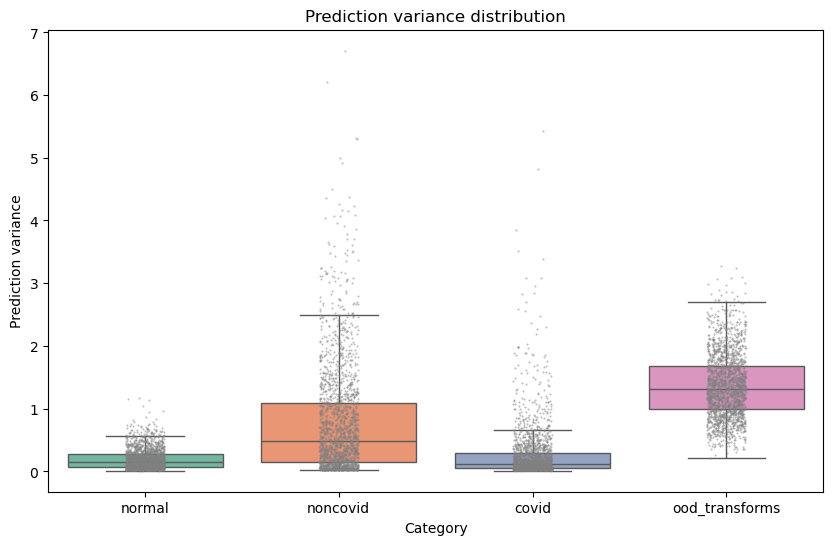


Kruskal-Wallis H-test for prediction variance equality:
Test Statistic (H): 3928.8751
P-value: 0.0000
The result is statistically significant (p < 0.05). This suggests that at least one category has a different prediction variance.

Since the Kruskal-Wallis test is significant, Dunn's test for prediction variance can be performed.

Dunn's test pairwise comparisons (p-values):
Comparison between covid and noncovid: p-value = 0.0000 (significant difference)
Comparison between covid and normal: p-value = 0.4017 (no significant difference)
Comparison between covid and ood_transforms: p-value = 0.0000 (significant difference)
Comparison between noncovid and normal: p-value = 0.0000 (significant difference)
Comparison between noncovid and ood_transforms: p-value = 0.0000 (significant difference)
Comparison between normal and ood_transforms: p-value = 0.0000 (significant difference)


({'statistic': 3928.8751299375726, 'p_value': 0.0},
                         covid       noncovid         normal  ood_transforms
 covid            1.000000e+00  4.386999e-142   4.017016e-01    0.000000e+00
 noncovid        4.386999e-142   1.000000e+00  5.579451e-133   1.937650e-182
 normal           4.017016e-01  5.579451e-133   1.000000e+00    0.000000e+00
 ood_transforms   0.000000e+00  1.937650e-182   0.000000e+00    1.000000e+00)

In [62]:
plot_boxplot(category_variances, test_type='prediction variance', output_dir='plots', dpi=500)
perform_kruskal_dunn_test(category_variances, test_type='prediction variance')

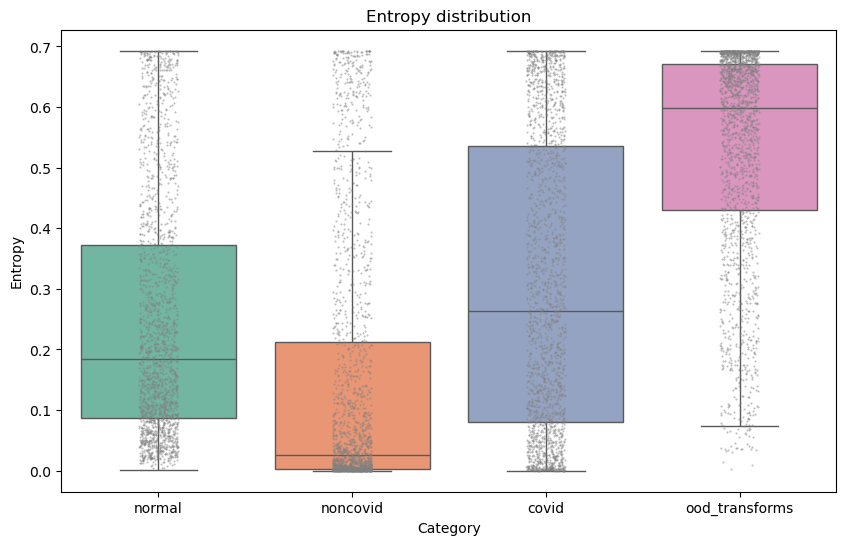


Kruskal-Wallis H-test for entropy equality:
Test Statistic (H): 2615.0593
P-value: 0.0000
The result is statistically significant (p < 0.05). This suggests that at least one category has a different entropy.

Since the Kruskal-Wallis test is significant, Dunn's test for entropy can be performed.

Dunn's test pairwise comparisons (p-values):
Comparison between covid and noncovid: p-value = 0.0000 (significant difference)
Comparison between covid and normal: p-value = 0.0000 (significant difference)
Comparison between covid and ood_transforms: p-value = 0.0000 (significant difference)
Comparison between noncovid and normal: p-value = 0.0000 (significant difference)
Comparison between noncovid and ood_transforms: p-value = 0.0000 (significant difference)
Comparison between normal and ood_transforms: p-value = 0.0000 (significant difference)


({'statistic': 2615.0592729666278, 'p_value': 0.0},
                         covid       noncovid         normal  ood_transforms
 covid            1.000000e+00  1.486657e-127   2.461781e-06   2.997008e-156
 noncovid        1.486657e-127   1.000000e+00   4.035807e-83    0.000000e+00
 normal           2.461781e-06   4.035807e-83   1.000000e+00   1.252711e-215
 ood_transforms  2.997008e-156   0.000000e+00  1.252711e-215    1.000000e+00)

In [63]:
plot_boxplot(category_entropies, test_type='entropy', output_dir='plots', dpi=500)
perform_kruskal_dunn_test(category_entropies, test_type='entropy')

## Conclusions
- The model achieved an overall accuracy of 93.3% in classifying normal vs non-covid infection radiographs.
- OOD transformations of normal radiographs lead to severe misclassification of the radiographs (Normal: 636 vs Non-COVID: 1364).
- COVID-19 infections cannot be detected as ood based on epistemic uncertainty or entropy after the model is trained on only normal and non-covid infection data.
- The Bayesian model reveals a high extent of epistemic uncertainty and a low entropy of predictions for non-covid infections compared to normal radiographs. The epistemic source of uncertainty for the non-covid infection class is only possible thanks to the Bayesian model framework.
- ood transforms of normal data show high epistemic uncertainty, as expected.